In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Function to reduce memory usage of the dataset

In [ ]:

def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df



Putting dataset of 5min for 1 year

In [ ]:
data = pd.read_excel('https://github.com/cruveilc/Occupancy-Forecasting/blob/main/output.xlsx?raw=true',
sheet_name=0,
header=0,
index_col=[0],
keep_default_na=True
).pipe(reduce_mem_usage, verbose=True)

#data = data[data.index.dayofweek < 5]
#data = data.between_time('06:00','23:00')
data=data[['label']]
time = data.index

Mem. usage decreased to  3.24 Mb (48.4% reduction)


In [ ]:
data

,label,NewDateTime
NewDateTime,,
2015-01-06 15:00:00,1.128000,2015-01-06 15:00:00
2015-01-06 15:05:00,0.622000,2015-01-06 15:05:00
2015-01-06 15:10:00,0.634000,2015-01-06 15:10:00
2015-01-06 15:15:00,0.285733,2015-01-06 15:15:00
2015-01-06 15:20:00,0.094000,2015-01-06 15:20:00
...,...,...
2015-12-30 00:05:00,0.010000,2015-12-30 00:05:00
2015-12-30 00:10:00,0.010000,2015-12-30 00:10:00
2015-12-30 00:15:00,0.010000,2015-12-30 00:15:00


In [ ]:
df=data
df['NewDateTime'] = pd.to_datetime(df.index)
df.index = df['NewDateTime']
df_p = df.resample('H').mean()
df_p[df_p.isnull().any(axis=1)]=0.1
df_p=df_p.clip(lower=0.001)
df_p

,label
NewDateTime,
2015-01-06 15:00:00,0.272478
2015-01-06 16:00:00,1.830740
2015-01-06 17:00:00,1.842989
2015-01-06 18:00:00,2.603144
2015-01-06 19:00:00,2.724946
...,...
2015-12-29 20:00:00,0.001000
2015-12-29 21:00:00,0.011667
2015-12-29 22:00:00,0.009167


In [ ]:
time = df_p.index

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('label%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('label%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('label%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = time
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
     
    return agg

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
data2=df_p[['label']]

#print(data.iloc[:,0])
#labelEncoder = LabelEncoder()
#data.iloc[:,0] = labelEncoder.fit_transform(data.iloc[:,0])
values = data2.values
print(values.shape)
values = values.astype('float32')

(8578, 1)


In [ ]:
values

array([[0.27247778],
       [1.83074   ],
       [1.8429888 ],
       ...,
       [0.00916667],
       [0.01      ],
       [0.01      ]], dtype=float32)

In [ ]:

n_in = 24
n_out=24
#scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()
#scaled = scaler.fit_transform(values)
reframed = series_to_supervised(values,n_in,n_out)

Importing the calendar and creating a calendar dataframe

In [ ]:
!pip install icalendar

In [ ]:
from icalendar import Calendar, Event
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import datetime

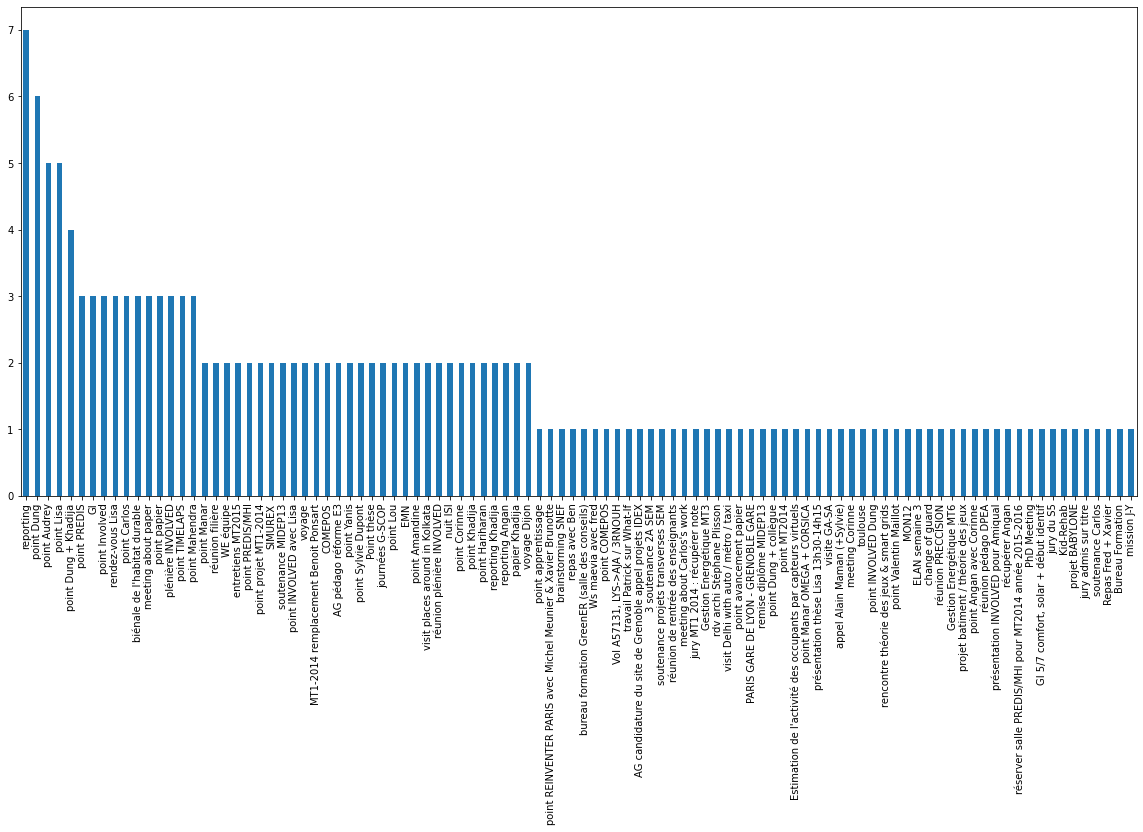

                                         evenement  ... label
debut                                               ...      
2015-01-05 09:15:00                          POO13  ...     1
2015-01-05 15:00:00        point Murielle sur DPEA  ...     2
2015-01-06 13:00:00                réunion mission  ...     1
2015-01-07 07:30:00              Rdv projet Ayesha  ...     1
2015-01-07 08:30:00  appeler amandine pour facture  ...     1

[5 rows x 4 columns]
Empty DataFrame
Columns: [evenement, debut, fin, label]
Index: []
fin test


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

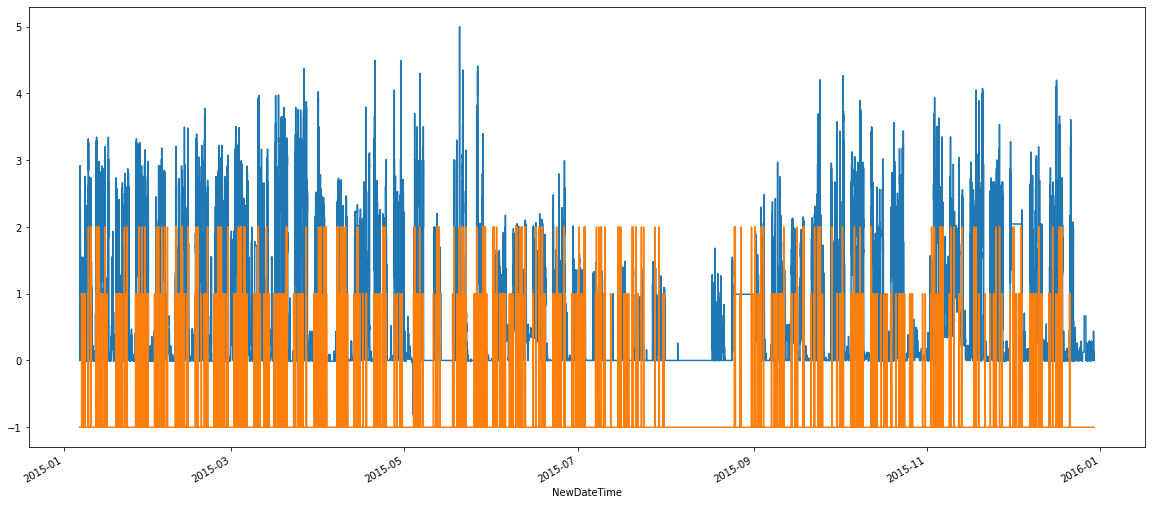

In [ ]:
evenement = []
debut = []
fin =[]


g = open('/content/stephane_stephane.ploix@gmail.com.ics','rb')
gcal = Calendar.from_ical(g.read().decode())
for component in gcal.walk():
    if component.name == "VEVENT":

        evenement.append(str((component.get('summary'))))
        if len(str(component.get('dtstart').dt)) >12:
            debut.append(datetime.strptime(str(component.get('dtstart').dt)[:-6],'%Y-%m-%d %H:%M:%S'))
        else:
            debut.append(datetime.strptime(str(component.get('dtstart').dt), '%Y-%m-%d'))
        if component.get('dtend') is not None:
            fin.append(component.get('dtend').dt)
        else:
            fin.append("Nan")

g.close()

calendrier = pd.DataFrame({'evenement': evenement,'debut':debut,'fin':fin})
calendrier['debut'] =pd.to_datetime(calendrier.debut)
calendrier.sort_values(['debut'], inplace=True)
calendrier = calendrier.set_index(calendrier['debut'])
calendrier = calendrier['2015-01-04':'2015-12-31']


plt.figure(figsize=(20,9))
calendrier.evenement.value_counts()[0:100].plot.bar()
plt.show()

label = []
for k in calendrier.index:
    if "point" in calendrier['evenement'].loc[str(k)]:
        label.append(2)
    else:
        label.append(1)

calendrier['label']=label
print(calendrier.head())



cal = []
nom = []
for k in data['label']:
    cal.append(-1)
    nom.append("None")

data['calendrier'] = cal
data['nom']=nom

calendrier.drop_duplicates(subset ="debut",
                     keep = False, inplace = True)
print(calendrier[calendrier.index.duplicated()])
print("fin test")

for k in calendrier.index:
    if k in data.index:
        data['calendrier'].loc[str(k)] = calendrier['label'].loc[str(k)]
        data['nom'].loc[str(k)] = calendrier['evenement'].loc[str(k)]

plt.figure(figsize=(20,9))
data['label'].plot()
data['calendrier'].plot()
plt.show()

In [ ]:
reframed.insert(0,'hour',reframed.index.hour)
reframed.insert(0,'dayofweek',reframed.index.dayofweek)
reframed.insert(0,'dayofmonth',reframed.index.day)
reframed.insert(0,'year',reframed.index.year)


In [ ]:
def calendar_feature(df):
  k = range(1,n_out)
  agg_list = [
        [['time'], 'calendrier',k,

    ]]
    
  for i, item in enumerate(agg_list):
        print(i)
        
        # unpack the parameters
        groupby_cols, target_col, lags = item
        groupby_col_str = "_".join(groupby_cols)
        
        for lag in lags:
                col_name = '_'+target_col+'_per_'+groupby_col_str+'_r''-_lag_'+str(lag)
                #df[col_name] = df[target_col].apply(lambda x: x.rolling(window=rolling_window).agg(agg_function).shift(lag))
                df[col_name] = df[target_col].shift(-lag)
    ## price related features
    #df['sell_price_norm'] = df['sell_price'] / df['max_sell_price_per_store_id_item_id_r365_lag_1']
    #df['sell_price_momentum'] = df['sell_price'] / df['mean_sell_price_per_store_id_item_id_r7_lag_1']

  return df

In [ ]:
data3 = calendar_feature(data)
#data2 = calendar_feature(data2)

0


In [ ]:
data3=data3.drop(['label','nom'],axis=1)


In [ ]:
reframed = data3[reframed.index[0]:reframed.index[-1]].merge(reframed,left_index=True,right_index=True)

In [ ]:
reframed1=reframed

In [ ]:
reframed.columns

Index(['NewDateTime', 'calendrier', '_calendrier_per_time_r-_lag_1',
       '_calendrier_per_time_r-_lag_2', '_calendrier_per_time_r-_lag_3',
       '_calendrier_per_time_r-_lag_4', '_calendrier_per_time_r-_lag_5',
       '_calendrier_per_time_r-_lag_6', '_calendrier_per_time_r-_lag_7',
       '_calendrier_per_time_r-_lag_8', '_calendrier_per_time_r-_lag_9',
       '_calendrier_per_time_r-_lag_10', '_calendrier_per_time_r-_lag_11',
       '_calendrier_per_time_r-_lag_12', '_calendrier_per_time_r-_lag_13',
       '_calendrier_per_time_r-_lag_14', '_calendrier_per_time_r-_lag_15',
       '_calendrier_per_time_r-_lag_16', '_calendrier_per_time_r-_lag_17',
       '_calendrier_per_time_r-_lag_18', '_calendrier_per_time_r-_lag_19',
       '_calendrier_per_time_r-_lag_20', '_calendrier_per_time_r-_lag_21',
       '_calendrier_per_time_r-_lag_22', '_calendrier_per_time_r-_lag_23',
       'year', 'dayofmonth', 'dayofweek', 'hour', 'label1(t-24)',
       'label1(t-23)', 'label1(t-22)', 'label1(t

In [ ]:
reframed1=reframed1.drop(columns="NewDateTime")

In [ ]:
reframed1

,calendrier,_calendrier_per_time_r-_lag_1,_calendrier_per_time_r-_lag_2,_calendrier_per_time_r-_lag_3,_calendrier_per_time_r-_lag_4,_calendrier_per_time_r-_lag_5,_calendrier_per_time_r-_lag_6,_calendrier_per_time_r-_lag_7,_calendrier_per_time_r-_lag_8,_calendrier_per_time_r-_lag_9,_calendrier_per_time_r-_lag_10,_calendrier_per_time_r-_lag_11,_calendrier_per_time_r-_lag_12,_calendrier_per_time_r-_lag_13,_calendrier_per_time_r-_lag_14,_calendrier_per_time_r-_lag_15,_calendrier_per_time_r-_lag_16,_calendrier_per_time_r-_lag_17,_calendrier_per_time_r-_lag_18,_calendrier_per_time_r-_lag_19,_calendrier_per_time_r-_lag_20,_calendrier_per_time_r-_lag_21,_calendrier_per_time_r-_lag_22,_calendrier_per_time_r-_lag_23,year,dayofmonth,dayofweek,hour,label1(t-24),label1(t-23),label1(t-22),label1(t-21),label1(t-20),label1(t-19),label1(t-18),label1(t-17),label1(t-16),label1(t-15),label1(t-14),label1(t-13),label1(t-12),label1(t-11),label1(t-10),label1(t-9),label1(t-8),label1(t-7),label1(t-6),label1(t-5),label1(t-4),label1(t-3),label1(t-2),label1(t-1),label1(t),label1(t+1),label1(t+2),label1(t+3),label1(t+4),label1(t+5),label1(t+6),label1(t+7),label1(t+8),label1(t+9),label1(t+10),label1(t+11),label1(t+12),label1(t+13),label1(t+14),label1(t+15),label1(t+16),label1(t+17),label1(t+18),label1(t+19),label1(t+20),label1(t+21),label1(t+22),label1(t+23)
NewDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-07 15:00:00,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015,7,2,15,0.272478,1.830740,1.842989,2.603144,2.724946,2.350104,1.988613,1.305453,0.216000,0.650167,0.063172,0.251251,0.327167,0.361500,0.394167,0.166667,0.082918,0.087667,0.337311,0.067833,0.001667,0.006387,0.005764,0.175452,0.010738,0.088514,0.009605,0.025667,0.486351,0.068091,0.034000,0.014833,0.017333,0.001000,0.013000,0.006000,0.006000,0.013003,0.142519,0.015754,0.006000,0.015003,0.169917,1.437893,1.908919,2.424207,1.922431,0.502113
2015-01-07 16:00:00,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015,7,2,16,1.830740,1.842989,2.603144,2.724946,2.350104,1.988613,1.305453,0.216000,0.650167,0.063172,0.251251,0.327167,0.361500,0.394167,0.166667,0.082918,0.087667,0.337311,0.067833,0.001667,0.006387,0.005764,0.175452,0.010738,0.088514,0.009605,0.025667,0.486351,0.068091,0.034000,0.014833,0.017333,0.001000,0.013000,0.006000,0.006000,0.013003,0.142519,0.015754,0.006000,0.015003,0.169917,1.437893,1.908919,2.424207,1.922431,0.502113,0.143371
2015-01-07 17:00:00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015,7,2,17,1.842989,2.603144,2.724946,2.350104,1.988613,1.305453,0.216000,0.650167,0.063172,0.251251,0.327167,0.361500,0.394167,0.166667,0.082918,0.087667,0.337311,0.067833,0.001667,0.006387,0.005764,0.175452,0.010738,0.088514,0.009605,0.025667,0.486351,0.068091,0.034000,0.014833,0.017333,0.001000,0.013000,0.006000,0.006000,0.013003,0.142519,0.015754,0.006000,0.015003,0.169917,1.437893,1.908919,2.424207,1.922431,0.502113,0.143371,0.192738
2015-01-07 18:00:00,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015,7,2,18,2.603144,2.724946,2.350104,1.988613,1.305453,0.216000,0.650167,0.063172,0.251251,0.327167,0.361500,0.394167,0.166667,0.082918,0.087667,0.337311,0.067833,0.001667,0.006387,0.005764,0.175452,0.010738,0.088514,0.009605,0.025667,0.486351,0.068091,0.034000,0.014833,0.017333,0.001000,0.013000,0.006000,0.006000,0.013003,0.142519,0.015754,0.006000,0.015003,0.169917,1.437893,1.908919,2.424207,1.922431,0.502113,0.143371,0.192738,0.972180
2015-01-07 19:00:00,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015,7,2,19,2.724946,2.350104,1.988613,1.305453,0.216000,0.650167,0.063172,0.251251,0.327167,0.361

In [ ]:
n_col = len(reframed1.columns)

In [ ]:
values1 = reframed1.values
n_train = 6000
n_in=n_col-n_out
train = values1[:n_train]
test = values1[n_train:]
trainX,trainY = train[:,:-n_out],train[:,n_in:]
testX,testY = test[:,:-n_out],test[:,n_in:]

print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(6000, 52) (6000, 24) (2531, 52) (2531, 24)


In [ ]:
#trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
#testX = testX.reshape(testX.shape[0],1,testX.shape[1])

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
epochs = 500
batch = 20
lr = 0.001

adam = optimizers.Adam(lr)

model_mlp = Sequential()
model_mlp.add(Dense(n_in, activation='relu', input_dim=n_in))
model_mlp.add(Dense(n_in))


model_mlp.add(Dense(n_out))
model_mlp.compile(loss='mse', optimizer=adam)

In [ ]:
model_mlp.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 52)                2756      
_________________________________________________________________
dense_46 (Dense)             (None, 52)                2756      
_________________________________________________________________
dense_47 (Dense)             (None, 24)                1272      
Total params: 6,784
Trainable params: 6,784
Non-trainable params: 0
_________________________________________________________________


In [ ]:

mlp_history = model_mlp.fit(trainX, trainY,epochs=epochs, verbose=2)


Epoch 1/500
188/188 - 0s - loss: 305.2873
Epoch 2/500
188/188 - 0s - loss: 1.1672
Epoch 3/500
188/188 - 0s - loss: 1.0236
Epoch 4/500
188/188 - 0s - loss: 0.9233
Epoch 5/500
188/188 - 0s - loss: 0.8471
Epoch 6/500
188/188 - 0s - loss: 0.7947
Epoch 7/500
188/188 - 0s - loss: 0.7442
Epoch 8/500
188/188 - 0s - loss: 0.7130
Epoch 9/500
188/188 - 0s - loss: 0.6753
Epoch 10/500
188/188 - 0s - loss: 0.6712
Epoch 11/500
188/188 - 0s - loss: 0.6424
Epoch 12/500
188/188 - 0s - loss: 0.6299
Epoch 13/500
188/188 - 0s - loss: 0.6250
Epoch 14/500
188/188 - 0s - loss: 0.6269
Epoch 15/500
188/188 - 0s - loss: 0.6067
Epoch 16/500
188/188 - 0s - loss: 0.6167
Epoch 17/500
188/188 - 0s - loss: 0.6277
Epoch 18/500
188/188 - 0s - loss: 0.6190
Epoch 19/500
188/188 - 0s - loss: 0.6080
Epoch 20/500
188/188 - 0s - loss: 0.6250
Epoch 21/500
188/188 - 0s - loss: 0.6285
Epoch 22/500
188/188 - 0s - loss: 0.6097
Epoch 23/500
188/188 - 0s - loss: 0.6367
Epoch 24/500
188/188 - 0s - loss: 0.6485
Epoch 25/500
188/188 - 

In [ ]:
testX

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
         1.11053777e+00,  1.57274449e+00,  1.63411283e+00],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
         1.57274449e+00,  1.63411283e+00,  1.65831673e+00],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
         1.63411283e+00,  1.65831673e+00,  1.27502835e+00],
       ...,
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
         1.00000005e-03,  9.36515164e-03,  1.19856060e-01],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
         9.36515164e-03,  1.19856060e-01,  1.23000003e-01],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
         1.19856060e-01,  1.23000003e-01,  1.23000003e-01]])

In [ ]:
yhat = model_mlp.predict(testX, verbose=0)

In [ ]:
yhat[-50]

array([ 0.00976944,  0.3582546 ,  0.03937181,  0.10120211, -0.5539061 ,
       -0.50124526, -0.18973067, -0.34189376, -0.11602659, -0.06388248,
        0.9501974 , -0.05371198,  0.38722387,  0.5583924 , -0.13537027,
        0.7383735 ,  0.27679774,  0.69538516,  0.26975602,  0.6523277 ,
        0.4467665 ,  0.27138835,  0.18289594,  0.40175292], dtype=float32)

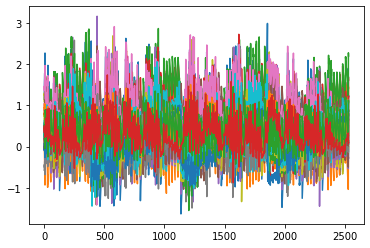

In [ ]:
plt.plot(yhat)

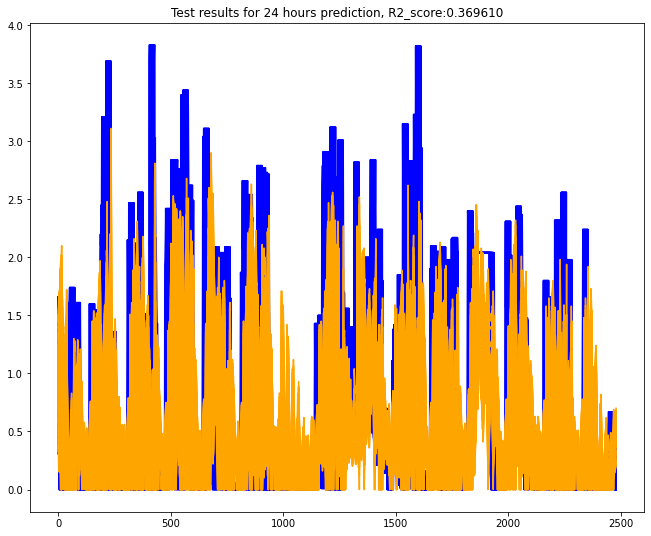

In [ ]:
from sklearn.metrics import r2_score
yhat[yhat <= 0.1] = 0
#ypred=ypred.reshape((testY.shape[0]))
plt.figure(figsize=(11,9))
plt.plot(testY[0:-50].round(2),label='Orginal',color = 'blue')
plt.plot(yhat[0:-50].round(2),label='Predicted',color = 'Orange')
plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(testY[0:-50],yhat[0:-50]))
plt.show()
#plt.legend(loc='best')

In [ ]:
label_col = ['label']

In [ ]:
sales_by_date

Hyperparameter tuning

In [ ]:



X_train = sales_by_date[feature_cols][0 : 60000]
y_train = sales_by_date[label_col][0:60000]

X_test = sales_by_date[feature_cols][60000:]
y_test = sales_by_date[label_col][60000:]

In [ ]:
X_test

In [ ]:
X_train.isna().sum()

In [ ]:
print("train", X_train.shape, y_train.shape)
print("test", X_test.shape, y_test.shape)

In [ ]:
import gc
gc.collect()

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

## define a 3-fold time-series split for cross validation

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
## the parameter table for tuninig

param_dist = {
    'boosting_type': ['gbdt'],
    'objective': ['tweedie'],
    'tweedie_variance_power': [1.1],
    'n_estimators': [500],
    'metric': ['rmse'],
    'max_depth': [30, 50, 70],
    'num_leaves': [250, 500, 1000],
    'learning_rate': [0.03, 0.1],
    'feature_fraction': [0.5, 0.7],
    'bagging_fraction': [0.5, 0.7],
}

reg = lgb.LGBMRegressor()

In [ ]:
## Set n_iter_search to be a higher value for actual hyperparameter tuning
## This is just to show the workflow

n_iter_search = 1

random_search = RandomizedSearchCV(
    reg,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)

In [ ]:
%%time

## Train on the training portion of the CV
## Validated on the validation/test portion of the CV
## Early stopping using the test portion of the dataset

random_search.fit(
    X_train,
    y_train,
    eval_metric='rmse',
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=1,
)

In [ ]:
## take the best model from our randomized search

reg_model = random_search.best_estimator_

In [ ]:
## examine the feature importane
## ideally, one wants a good balance between recursive features (lag/rolling depends on data within 28 days) and solid features

lgb.plot_importance(reg_model, figsize=(10, 300))

Error analysis

In [ ]:
sales_by_date

In [ ]:
def update_features_one_day(df, time):
    '''
    update lag/rolling features for one day only
    
    used for submission creation, when the predictions for 28 days are performed recursively
    '''
    
    from datetime import timedelta
    
    agg_list = [

    [['time'], 'label', 'mean', [12*24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50,100,150], [1,2,3,4,5,10,15,20,25]],
        [['time'], 'label', 'mean', [7*12*24, 14*12*24, 30*12*24], [28]],
        [['time'], 'label', 'max', [365*12*24], [1*12*24]],
        [['time'], 'label', 'mean', [7*12*24], [1*12*24]],
        [['time'], 'calendrier', 'mean', [12*24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50,100,150], [1,2,3,4,5,10,15,20,25,7*12*17,14*12*17]],
    ]
    for i, item in enumerate(agg_list):
        print(i)
        # unpack the parameters
        groupby_cols, target_col, agg_function, rolling_windows, lags = item
        groupby_col_str = "_".join(groupby_cols)
        print(i+1)
        print(df.time)
        for lag in lags:
            print(i+2)
            for rolling_window in rolling_windows:
                print(i+3)
                col_name = agg_function+'_'+target_col+'_per_'+groupby_col_str+'_r'+str(rolling_window)+'_lag_'+str(lag)
                print(i+4)
                print(date-timedelta(hours=lag))
                print(df[(df.time <= date-timedelta(hours=lag))])
                df_window = df[(df.time <= date-timedelta(hours=lag)) & (df.time > date-timedelta(hours=lag+rolling_window))]
                print(df_window)
                print(i+5)
                df_window_grouped = df_window.agg({target_col : agg_function}).reindex(df.loc[df.time==time])
                print(i+6)
                print((df_window[target_col].values))
                df.loc[(df.time == time, col_name)] = df_window_grouped[target_col][0]


                #df[col_name] = df[target_col].rolling(rolling_window).agg(agg_function).shift(lag)
                
    #df.loc[df.date == date, 'sell_price_norm'] = df.loc[df.date == date, 'sell_price'] / df.loc[df.date == date, 'max_sell_price_per_store_id_item_id_r365_lag_1']
    #df.loc[df.date == date, 'sell_price_momentum'] = df.loc[df.date == date, 'sell_price'] / df.loc[df.date == date, 'mean_sell_price_per_store_id_item_id_r7_lag_1']
    
    return df

In [ ]:
from datetime import timedelta

In [ ]:
## perform recursive prediction

from datetime import datetime
from datetime import timedelta  

## create submission ID

# the magic scaling factor that applies on every score prediction
magic_factor = 1.0

# the threshold below which the prediction is set to zero
zero_threshold = 0.5

# start_date and the number of dates to be predicted
# this error analysis was performed when the validation set was not released. Please use 2016-04-24 to 2016-05-22 after the release


In [ ]:
print(len(sales_by_date_copy['label']))

In [ ]:
sales_by_date_copy = sales_by_date.copy()


sales_by_date_copy['label_true'] = sales_by_date_copy['label']
for k  in range(0,len(sales_by_date_copy['label_true'])):
  if sales_by_date_copy['label_true'][k]<0.5:
    sales_by_date_copy['label_true'][k] = 0
#sales_by_date_copy['label_true'] = sales_by_date_copy['label_true'].clip(lower=0.4)
sales_by_date_copy.reset_index(inplace=True)
month_pred= []
for j in range (1,15):
  start_date = datetime(2015,11,j)
  end_date = datetime(2015,11,j+1,0)
  num_dates = 12*24
# loop over days and generate score for each day
  for i in range(num_dates):

      date = start_date + 5*timedelta(minutes=i)
      #print(date)
      # compute the features on-the-fly b/c some features depend on predictions
      X_features = sales_by_date_copy
      X_pred = X_features[X_features['time'] == date][feature_cols]
      #print(X_pred)
      # generate predictions
      y_pred = reg_model.predict(X_pred) * magic_factor
      y_pred[y_pred <= zero_threshold] = 0
      month_pred.append(y_pred)
      # update predictions to the sales_by_date dataframe
      sales_by_date_copy.loc[sales_by_date_copy['time'] == date, 'label'] = y_pred

      ## Filter out the final table with our predictions

  sales_by_date_copy2 = sales_by_date_copy.set_index('time').loc[start_date:end_date].reset_index()
  #df_plot = sales_by_date_copy[(sales_by_date_copy.item_id == item_id) & (sales_by_date_copy.store_id == store_id)]
  plt.figure(figsize=(12, 8))
  plt.plot(sales_by_date_copy2.time, sales_by_date_copy2.label.round(1), label='pred',color="orange")
  plt.plot(sales_by_date_copy2.time, sales_by_date_copy2.label_true.round(1), label='true',color="blue")
  plt.legend()
  from sklearn.metrics import r2_score
  from sklearn.metrics import mean_squared_error

  plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(sales_by_date_copy2['label'].round(1),sales_by_date_copy2['label_true'].round(1)))

  

  print(r2_score(sales_by_date_copy2['label'],sales_by_date_copy2['label_true']))
  print(mean_squared_error(sales_by_date_copy2['label'],sales_by_date_copy2['label_true']))
